## Feature selection done by testing ridge regression  and lasso regression 
Compare both outputs of feature selections

Ridge regression has benefits when dealing with large ds and overfittign might be a porblem during model training. 
Ridge regression - in contrast to other models - doesnt directly nullify the inlfuence of less important feautres - good to determine variables with zero effects

"""
  https://medium.com/@sabarirajan.kumarappan/feature-selection-by-lasso-and-ridge-regression-python-code-examples-1e8ab451b94b
key difference however, between Ridge and Lasso regression is that Lasso Regression has the ability to nullify the impact of an irrelevant feature in the data, meaning that it can reduce the coefficient of a feature to zero thus completely eliminating it and hence is better at reducing the variance when the data consists of many insignificant features. Ridge regression, however, can not reduce the coefficients to absolute zero.
Ridge regression performs better when the data consists of features which are sure to be more relevant and useful.

"""

Code idea maily from: https://medium.com/@sabarirajan.kumarappan/feature-selection-by-lasso-and-ridge-regression-python-code-examples-1e8ab451b94b

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel



from sklearn.metrics import accuracy_score# , confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score

import matplotlib.pyplot as plt


seed = np.random.seed(11)


In [2]:
df_candidates = pd.read_excel("../../input_survey_data/survey_data_candidates_coords.xlsx")
df_candidates.tail(2)


,Target_direct,business_reduction,inundation_duration_h,water_depth_cm,warning_time_h,shp_damage_level_furniture,shp_damage_level_electronics,shp_damage_level_equipment,shp_damage_level_products,shp_damage_level_others,...,shp_employees,shp_avgmonthly_sale_mVND,shp_capital_mVND,shp_risk_behaviour,shp_monetary_resources_prenvention,building_floor,lat,lon,geometry,elevation_m
502,2.0,70.0,2.0,10,0.0,2,2,4,2,0,...,1,1,10.0,2,1,1,106.628290,10.723266,POINT (106.62829 10.723266),4.0
503,0.0,100.0,5.0,20,0.0,2,1,1,1,0,...,1,2,50.0,3,3,0,106.626656,10.716209,POINT (106.626656 10.716209),3.0


#### Split Data and Normalize variables 
- due that most bariables dont have a gaussian distribution, donwside is that distance to outliers is decreased so outliers have influence on the loss calculation (smaller standard deviations when using normaization)


In [3]:
# ## clean df from few nan values

print(df_candidates.isna().sum())
df_candidates = df_candidates.replace(np.nan, 0)




Target_direct                               0
business_reduction                          1
inundation_duration_h                       0
water_depth_cm                              0
warning_time_h                              0
shp_damage_level_furniture                  0
shp_damage_level_electronics                0
shp_damage_level_equipment                  0
shp_damage_level_products                   0
shp_damage_level_others                     0
shp_closed_d                                0
shp_duration_back2normal                    0
contaminations                              0
emergency_measures                          0
Q0.1                                        0
shp_damage_level_others_r.specify         504
shp_damage_level_others_s.specify         504
protect_valuables_impl                      0
water_barries_impl                          0
pumping_equipment_impl                      0
elevation_building_impl                     0
resistant_material_building_impl  

In [4]:
X_unscaled = df_candidates.drop(["Target_direct",
                        "shp_damage_level_others_r.specify", "shp_damage_level_others_s.specify",
                        #"shp_sector.specify",   # fix this variable and make as numerbs
                        "Q0.1",
                        "geometry","lat","lon"
                        ], axis=1)
y = df_candidates.Target_direct.astype("int64")


## normalize data 
scaler = MinMaxScaler() 
X = scaler.fit_transform(pd.DataFrame(X_unscaled))
y = scaler.fit_transform(pd.DataFrame(y))#.reshape(-1, 1))


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed, shuffle=True)


# classes have to start from zero on for XGB, make contious var as categorical 
le = LabelEncoder()
y_train = le.fit_transform(y_train)


c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
# param_dist = {'n_estimators': [10, 100, 200, 500],
#               'max_depth': [1, 3, 5, 10,20],
#               'colsample_bynode': [0.1, 0.3] # nbr of feautres for each split point
#               #'subsample': 0.8  # define subsample of train st, xgb has not bootstrapping
#               }


In [7]:

ridge_ = SelectFromModel(LogisticRegression(C=1, penalty="l2", solver="liblinear", random_state=seed))  # L2 = Strafterm = Ridge Regularizationridge_.fit(X_train, y) #np.ravel(y_train,order="C"))
ridge_.fit(X_train, y_train)
ridge_.get_support()

lasso_ = SelectFromModel(LogisticRegression(C=1, penalty="l1", solver="liblinear", random_state=seed))  # L1 =lasso Regression
lasso_.fit(X_train, y_train) #np.ravel(y_train,order="C"))
lasso_.get_support()

X_train = pd.DataFrame(X_train)


# ## predict unseen X_test set
# y_ridge_pred = ridge_.predict(X_test)
# y_lasso_pred = lasso_.predict(X_test)


In [8]:
selected_feat = X_train.columns[(ridge_.get_support())]
print("total features: {}".format((X_train.shape[1])))
print("selected features: {}".format(len(selected_feat)))
print("features with coefficients shrank to zero: {}".format(
np.sum(ridge_.estimator_.coef_ == 0)))


total features: 31
selected features: 12
features with coefficients shrank to zero: 48


In [9]:
selected_feat = X_train.columns[(lasso_.get_support())]
print("total features: {}".format((X_train.shape[1])))
print("selected features: {}".format(len(selected_feat)))
print("features with coefficients shrank to zero: {}".format(
np.sum(lasso_.estimator_.coef_ == 0)))


total features: 31
selected features: 24
features with coefficients shrank to zero: 648


### Evaluation

In [10]:
# np.sum(ridge_.coef_ >= 0)

lasso_.best

AttributeError: 'SelectFromModel' object has no attribute 'best'

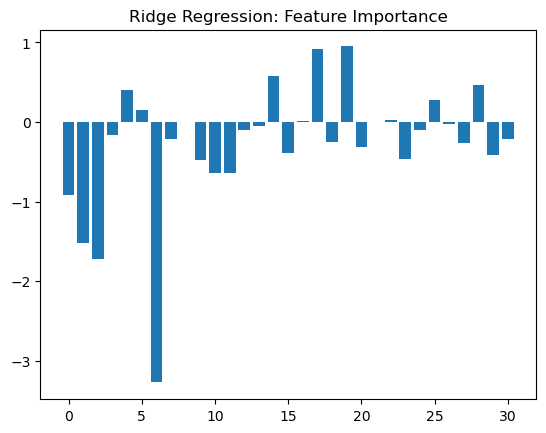

In [135]:
# plot feature importance

importance = ridge_.estimator_.coef_[0]
plt.bar([x for x in range(len(importance))], importance)
plt.title("Ridge Regression: Feature Importance")
plt.show()

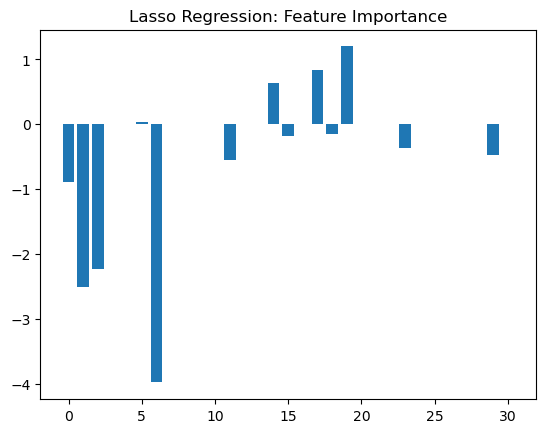

In [136]:
# plot feature importance
importance = lasso_.estimator_.coef_[0]
plt.title("Ridge Regression: Feature Importance")
plt.bar([x for x in range(len(importance))], importance)
plt.title("Lasso Regression: Feature Importance")
plt.show()

In [137]:
# # define the model evaluation by k-fold CV
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate the model and collect the scores
# n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [140]:
#importance.shape
t = ridge_.get_support()
print(t)
print(X_unscaled.columns[t])
#X_unscaled.columns[ridge_.get_support()
#X_train[(ridge_.estimator_.coef_ == 0)#]

[ True False  True False False False  True False False False False False
 False  True  True  True  True  True  True  True  True False False False
 False False False False False  True False]
Index(['business_reduction', 'water_depth_cm', 'shp_damage_level_equipment',
       'protect_valuables_impl', 'water_barries_impl',
       'pumping_equipment_impl', 'elevation_building_impl',
       'resistant_material_building_impl', 'electricity_higher_impl',
       'flood_protections_impl', 'elevation_building_height_cm',
       'building_floor'],
      dtype='object')


## Write selected features to disk


In [164]:
#print(X_unscaled.columns[t].to_list())
#print()
df_ridge = df_candidates[X_unscaled.columns[ridge_.get_support()].to_list()+["Target_direct"]]
df_lasso = df_candidates[X_unscaled.columns[lasso_.get_support()].to_list()+["Target_direct"]]
df_ridge.info()
df_ridge.to_excel("../../input_survey_data/survey_data_candidates_ridge.xlsx", index=False)
df_lasso.to_excel("../../input_survey_data/survey_data_candidates_lasso.xlsx", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   business_reduction                504 non-null    float64
 1   water_depth_cm                    504 non-null    int64  
 2   shp_damage_level_equipment        504 non-null    int64  
 3   protect_valuables_impl            504 non-null    int64  
 4   water_barries_impl                504 non-null    int64  
 5   pumping_equipment_impl            504 non-null    int64  
 6   elevation_building_impl           504 non-null    int64  
 7   resistant_material_building_impl  504 non-null    int64  
 8   electricity_higher_impl           504 non-null    int64  
 9   flood_protections_impl            504 non-null    int64  
 10  elevation_building_height_cm      504 non-null    int64  
 11  building_floor                    504 non-null    int64  
 12  Target_d

In [139]:
removed_feats = X_train.columns[(ridge_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

X_train_selected = ridge_.transform(X_train)
X_test_selected = ridge_.transform(X_test)
X_train_selected.shape, X_test_selected.shape

IndexError: boolean index did not match indexed array along dimension 0; dimension is 31 but corresponding boolean dimension is 744

In [97]:
#X.columns#[(lasso_.estimator_.coef_ == 0).ravel().tolist()]
X_train.columns[(lasso_.get_support())]
print("features with coefficients shrank to zero: {}".format(
np.sum(lasso_.estimator_.coef_ == 0)))

features with coefficients shrank to zero: 617


In [82]:
removed_feats = X_train.columns[(lasso_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

X_train_selected = lasso_.transform(X_train)
X_test_selected = lasso_.transform(X_test)
X_train_selected.shape, X_test_selected.shape

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed